In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap

Number of zip code areas: 178
Available columns: ['modzcta', 'label', 'zcta', 'pop_est', 'ZCTA', 'Median_Household_Income', 'Bachelors_Degree_or_Higher', 'Income_Normalized', 'Education_Normalized', 'Affluence_Education_Score', 'Total_Population', 'Population_25_to_44', 'Percent_25_to_44', 'White_Population', 'Asian_Population', 'Percent_White', 'Percent_Asian', 'Median_Home_Value', 'Median_Gross_Rent', 'geometry']
Sample area info: 10001 - 10001, 10118


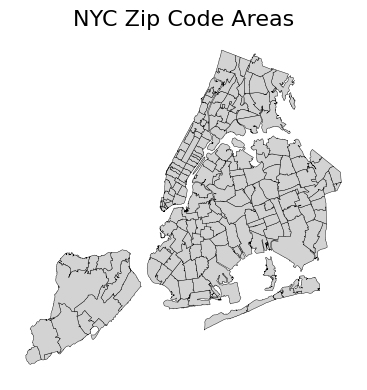

In [2]:
file_path = "cleaned_data/merged_final_data.geojson"
nyc_data = gpd.read_file(file_path)

# Basic information about the data
print(f"Number of zip code areas: {len(nyc_data)}")
print(f"Available columns: {nyc_data.columns.tolist()}")
print(f"Sample area info: {nyc_data.iloc[0]['modzcta']} - {nyc_data.iloc[0]['label']}")

# Create a basic plot of all zip code areas
fig, ax = plt.subplots(figsize=(4, 4))
nyc_data.plot(ax=ax, edgecolor='black', linewidth=0.3, color='lightgrey')
ax.set_title("NYC Zip Code Areas", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()
plt.close()

Number of high income ZIP areas (>$100K): 86


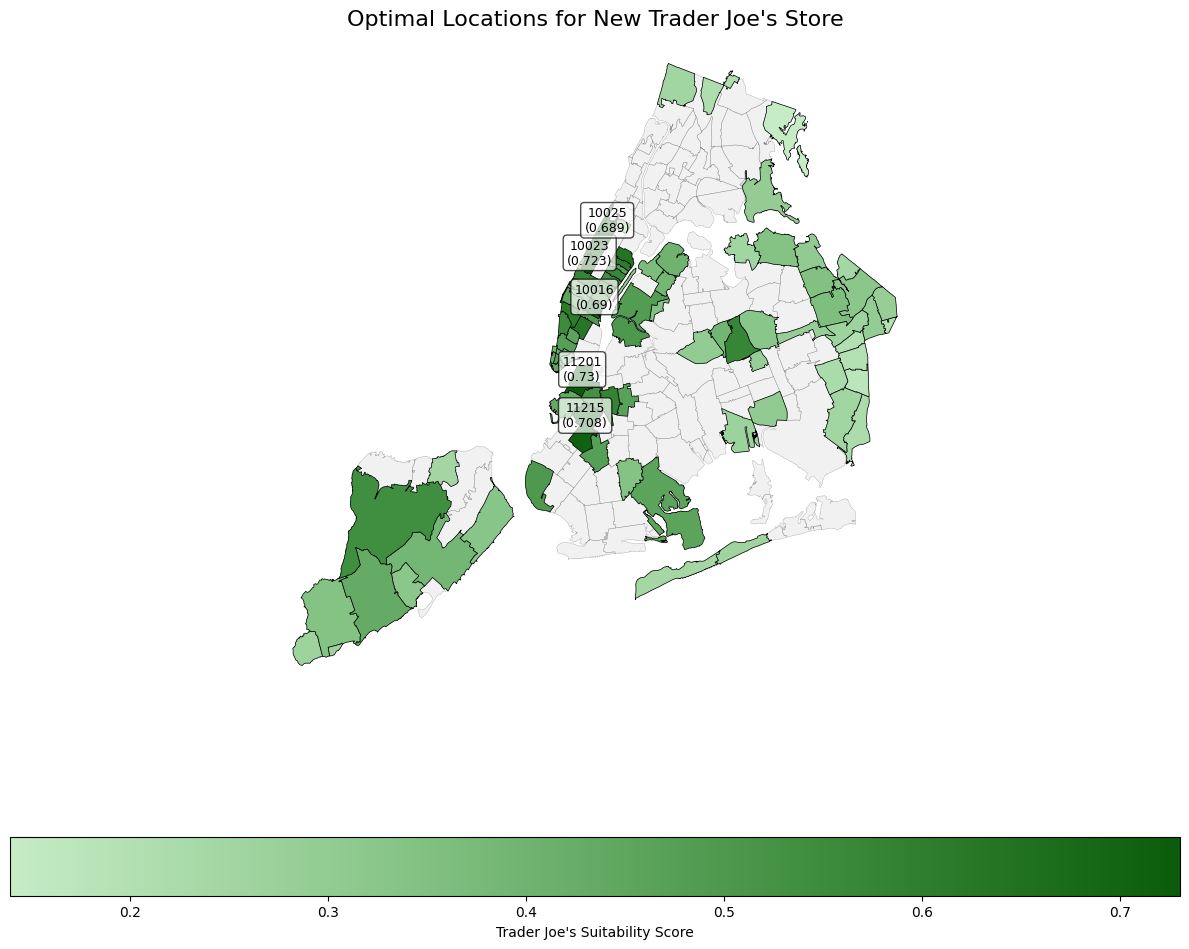


Top 10 Most Suitable ZIP Codes for Trader Joe's:


ZCTA TJ_Score Median_Household_Income  Total_Population  \
89   11201    0.730                $244,063           69251.0   
21   10023    0.723                $250,000           67468.0   
103  11215    0.708                $223,697           70922.0   
14   10016    0.690                $250,000           54297.0   
23   10025    0.689                $157,394           93223.0   
22   10024    0.684                $250,000           62576.0   
39   10128    0.636                $225,389           59000.0   
2    10003    0.630                $250,000           53825.0   
25   10028    0.612                $250,000           45679.0   
10   10011    0.610                $235,848           49344.0   

     Percent_25_to_44  Percent_White  Percent_Asian Education_Level  
89               43.4           60.4           14.4           84.6%  
21               31.3           67.6           16.2           92.4%  
103              39.5           71.2            9.1           86.8%  
14               45.8           62.0           19.9           71.6%  
23               31.1           57.8           10.1          100.0%  
22               30.2           81.0            4.8           86.0%  
39               33.4           70.5           10.5           75.0%  
2                35.6           67.2           17.9           60.7%  
25               34.8           84.5            7.0           63.2%  
10               35.8           71.6           10.4           65.8%

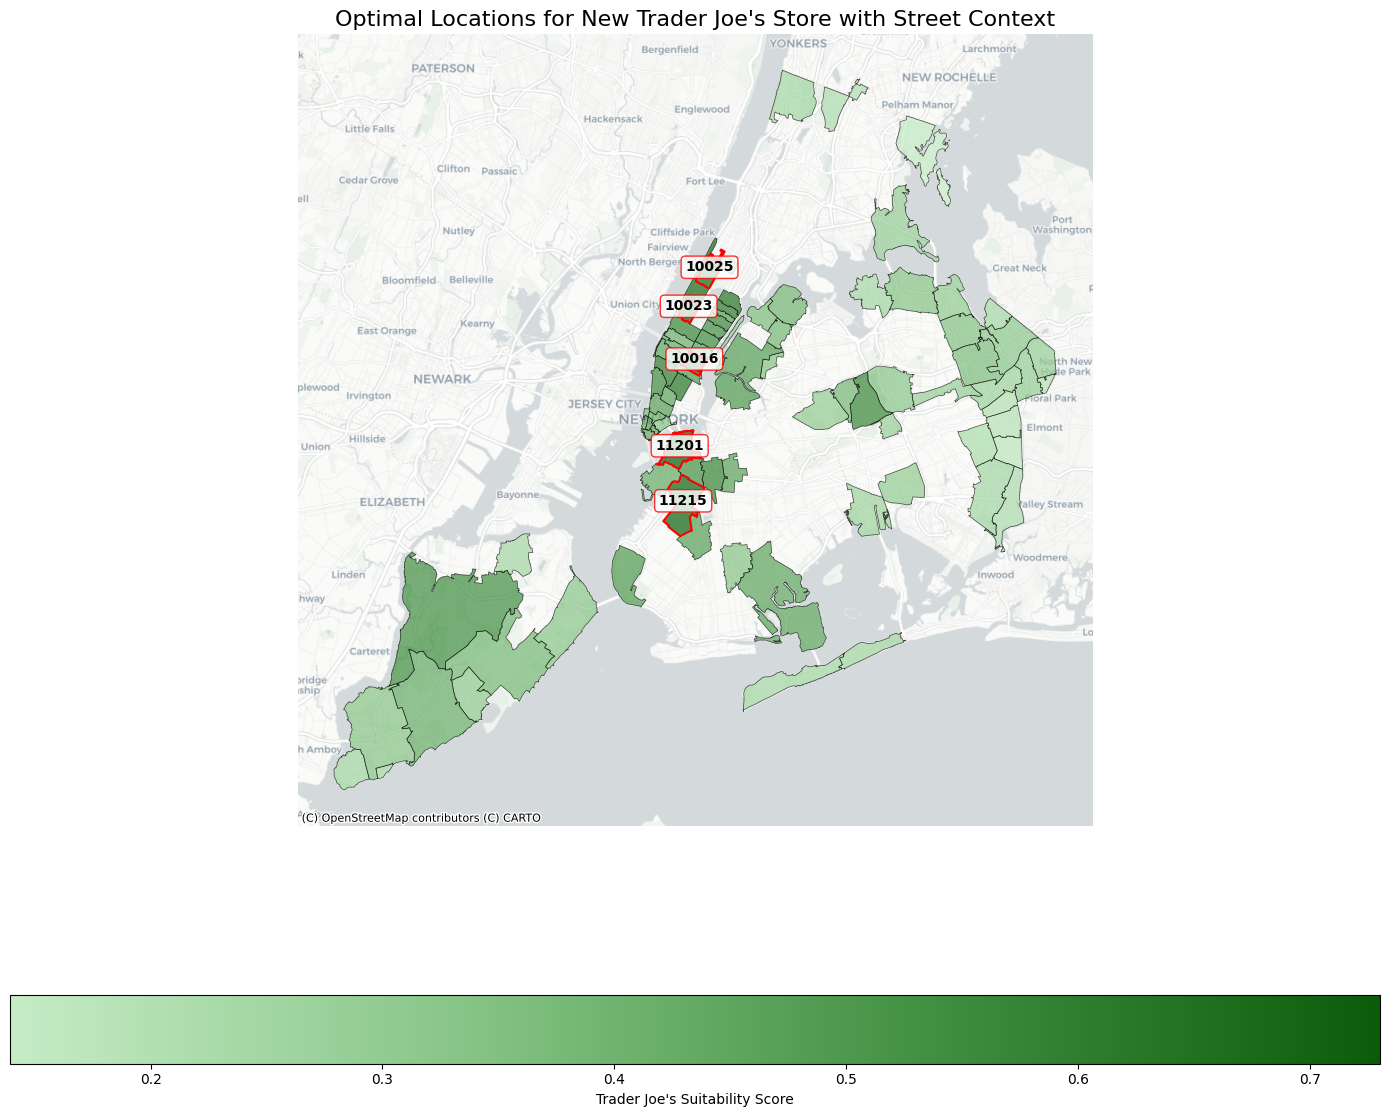

In [ ]:


# Filter for income > 120K
high_income_areas = nyc_data[nyc_data['Median_Household_Income'] > 100000].copy()
print(f"Number of high income ZIP areas (>$100K): {len(high_income_areas)}")

# Normalize remaining criteria (where not already normalized)
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize population 
high_income_areas['Population_Normalized'] = min_max_normalize(high_income_areas['Total_Population'])

# Create a composite score with custom weights
high_income_areas['TJ_Score'] = (
    0.20 * high_income_areas['Income_Normalized'] +          # Higher income
    0.25 * high_income_areas['Education_Normalized'] +       # Higher education
    0.20 * high_income_areas['Population_Normalized'] +      # Higher population
    0.15 * min_max_normalize(high_income_areas['Percent_25_to_44']) + # Young adults
    0.10 * min_max_normalize(high_income_areas['Percent_White']) +    # White population
    0.10 * min_max_normalize(high_income_areas['Percent_Asian'])      # Asian population
)

# Create a choropleth map of the suitability score
fig, ax = plt.subplots(figsize=(12, 10))

# Custom colormap for TJ suitability (green to dark green)
tj_cmap = LinearSegmentedColormap.from_list('tj_colors', ['#c6ecc6', '#86c486', '#429042', '#0a5c0a'])

# Plot all areas in light gray as background
nyc_data.plot(ax=ax, edgecolor='black', linewidth=0.3, color='lightgrey', alpha=0.3)

# Plot high income areas with suitability score
high_income_areas.plot(
    column='TJ_Score',
    cmap=tj_cmap,
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
)

# Identify and label top 5 most suitable areas
top_areas = high_income_areas.nlargest(, 'TJ_Score')
for idx, row in top_areas.iterrows():
    zipcode = row['ZCTA']
    score = round(row['TJ_Score'], 3)
    ax.annotate(f"{zipcode}\n({score})", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7))

ax.set_title("Optimal Locations for New Trader Joe's Store", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Display top 10 areas with detail
top_10 = high_income_areas.nlargest(10, 'TJ_Score')[['ZCTA', 'TJ_Score', 'Median_Household_Income', 
                                                    'Total_Population', 'Percent_25_to_44', 
                                                    'Percent_White', 'Percent_Asian', 
                                                    'Education_Normalized']]
print("\nTop 10 Most Suitable ZIP Codes for Trader Joe's:")
top_10_display = top_10.copy()
top_10_display['Education_Level'] = top_10_display['Education_Normalized'].apply(lambda x: f"{x*100:.1f}%")
top_10_display['TJ_Score'] = top_10_display['TJ_Score'].apply(lambda x: f"{x:.3f}")
top_10_display['Median_Household_Income'] = top_10_display['Median_Household_Income'].apply(lambda x: f"${int(x):,}")
display(top_10_display[['ZCTA', 'TJ_Score', 'Median_Household_Income', 'Total_Population',
                       'Percent_25_to_44', 'Percent_White', 'Percent_Asian', 'Education_Level']])

# Create a more detailed map with basemap
try:
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Convert to Web Mercator for compatibility with contextily
    high_income_areas_web = high_income_areas.to_crs(epsg=3857)
    
    # Plot with basemap for context
    high_income_areas_web.plot(
        column='TJ_Score',
        cmap=tj_cmap,
        legend=True,
        ax=ax,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Highlight top areas
    top_areas_web = high_income_areas_web.nlargest(5, 'TJ_Score')
    top_areas_web.plot(ax=ax, color='none', edgecolor='red', linewidth=1.5)
    
    # Add annotations
    for idx, row in top_areas_web.iterrows():
        zipcode = row['ZCTA']
        ax.annotate(zipcode, 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=10, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='red', alpha=0.8))
    
    ax.set_title("Optimal Locations for New Trader Joe's Store with Street Context", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error adding basemap: {e}")

Found 470 valid subway stations
Number of high income ZIP areas (>$120K): 58


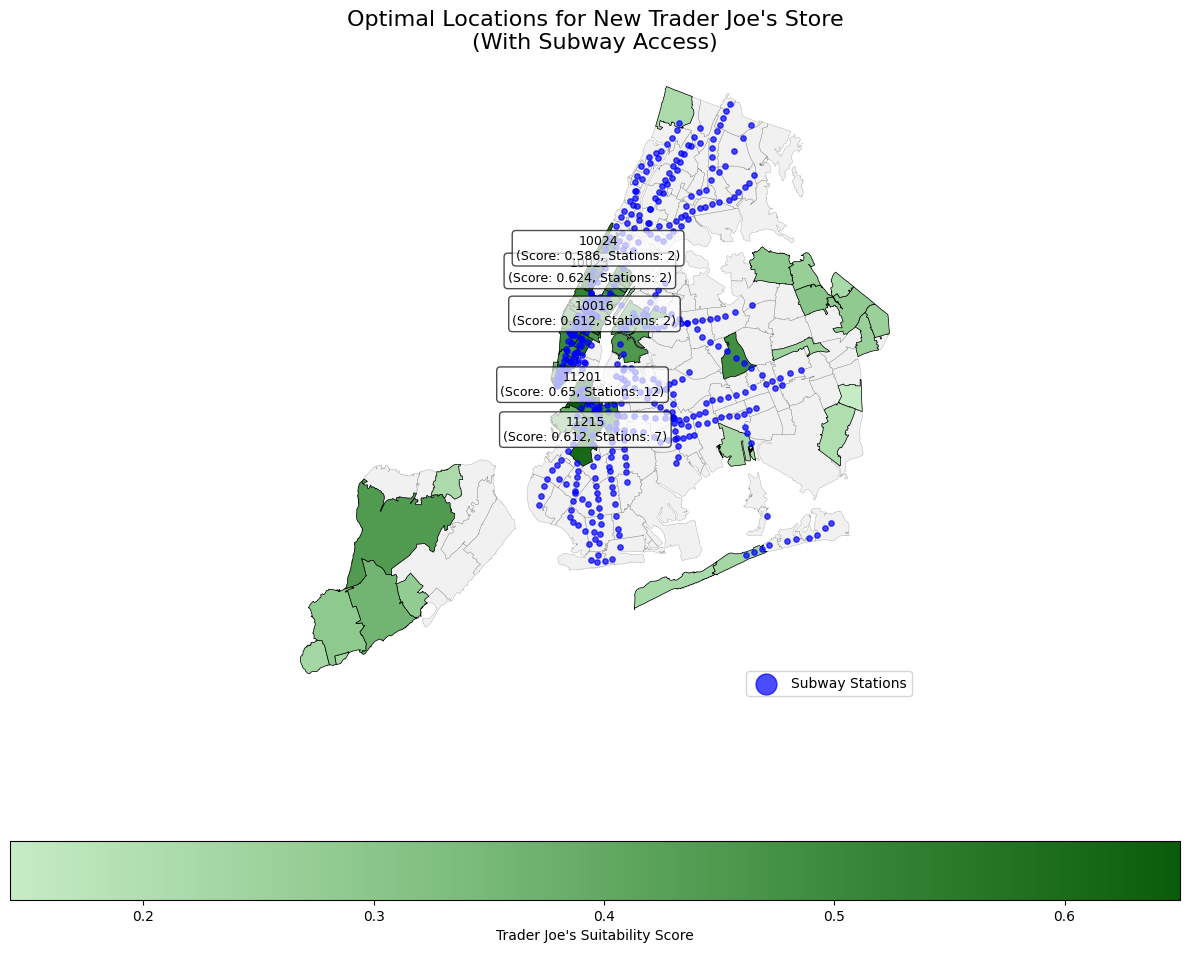

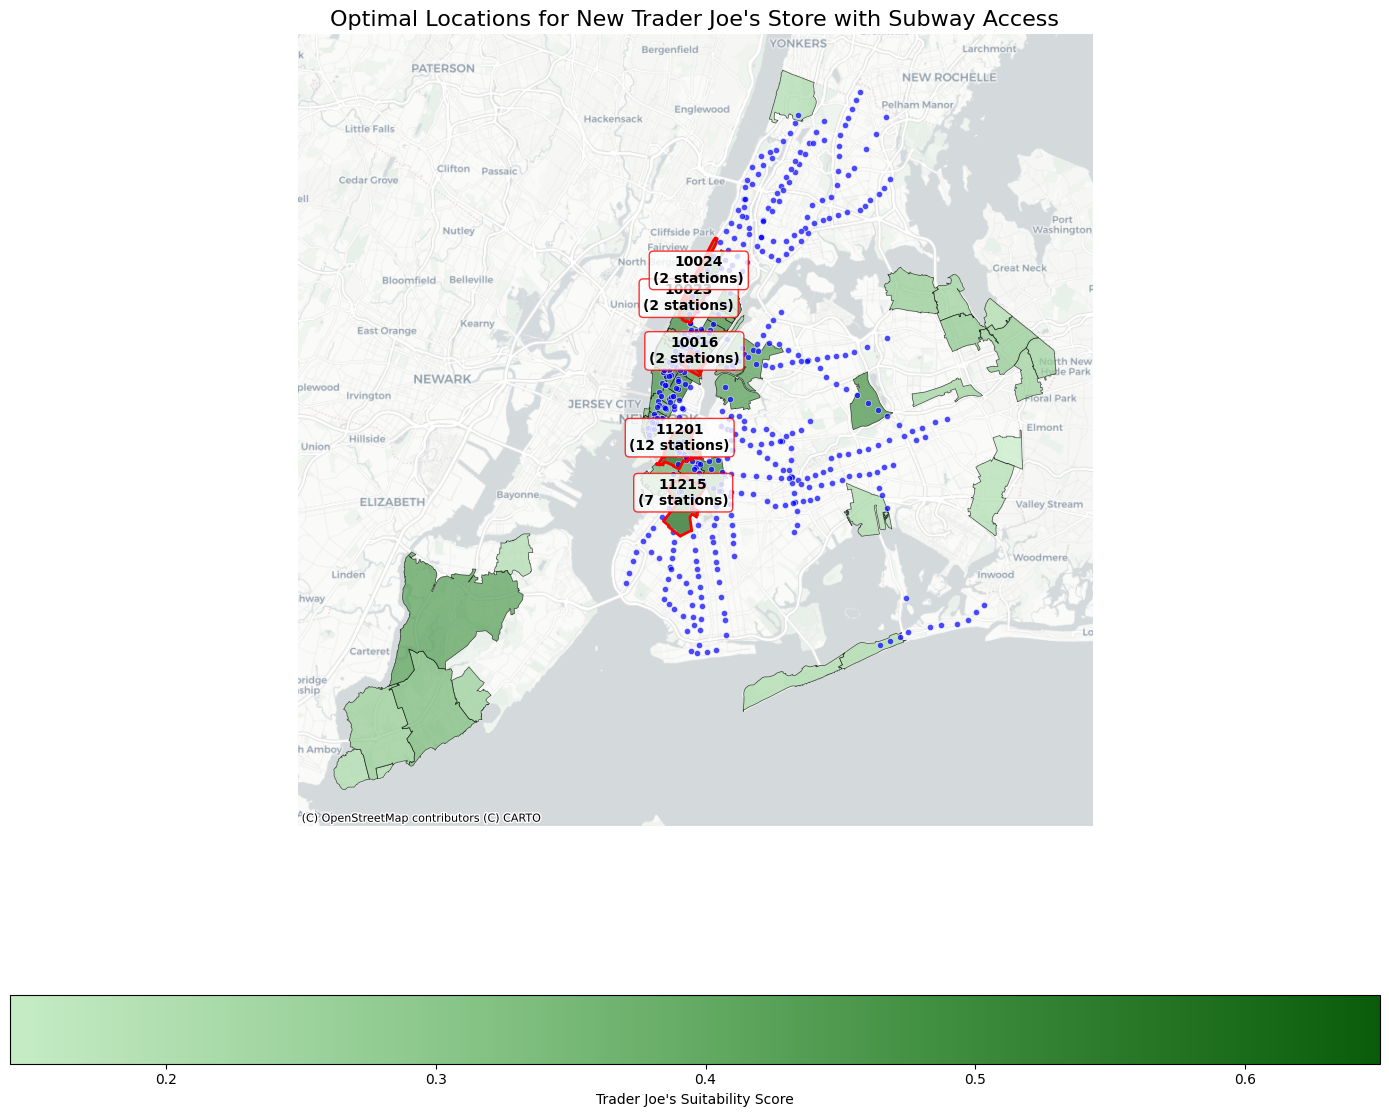


Top 10 Most Suitable ZIP Codes for Trader Joe's:


ZCTA TJ_Score Median_Household_Income  Total_Population  \
89   11201    0.650                $244,063           69251.0   
21   10023    0.624                $250,000           67468.0   
103  11215    0.612                $223,697           70922.0   
14   10016    0.612                $250,000           54297.0   
22   10024    0.586                $250,000           62576.0   
23   10025    0.584                $157,394           93223.0   
2    10003    0.577                $250,000           53825.0   
10   10011    0.565                $235,848           49344.0   
6    10006    0.562                $250,000            4475.0   
39   10128    0.548                $225,389           59000.0   

     Percent_25_to_44  Percent_White  Percent_Asian Education_Level  \
89               43.4           60.4           14.4           84.6%   
21               31.3           67.6           16.2           92.4%   
103              39.5           71.2            9.1           86.8%   
14               45.8           62.0           19.9           71.6%   
22               30.2           81.0            4.8           86.0%   
23               31.1           57.8           10.1          100.0%   
2                35.6           67.2           17.9           60.7%   
10               35.8           71.6           10.4           65.8%   
6                61.5           65.5           23.6            4.0%   
39               33.4           70.5           10.5           75.0%   

     subway_count Subway Density  
89             12   3.30 per km²  
21              2   1.57 per km²  
103             7   1.23 per km²  
14              2   1.45 per km²  
22              2   0.91 per km²  
23              4   2.06 per km²  
2               7   4.67 per km²  
10              9   5.58 per km²  
6               4  15.88 per km²  
39              1   0.85 per km²

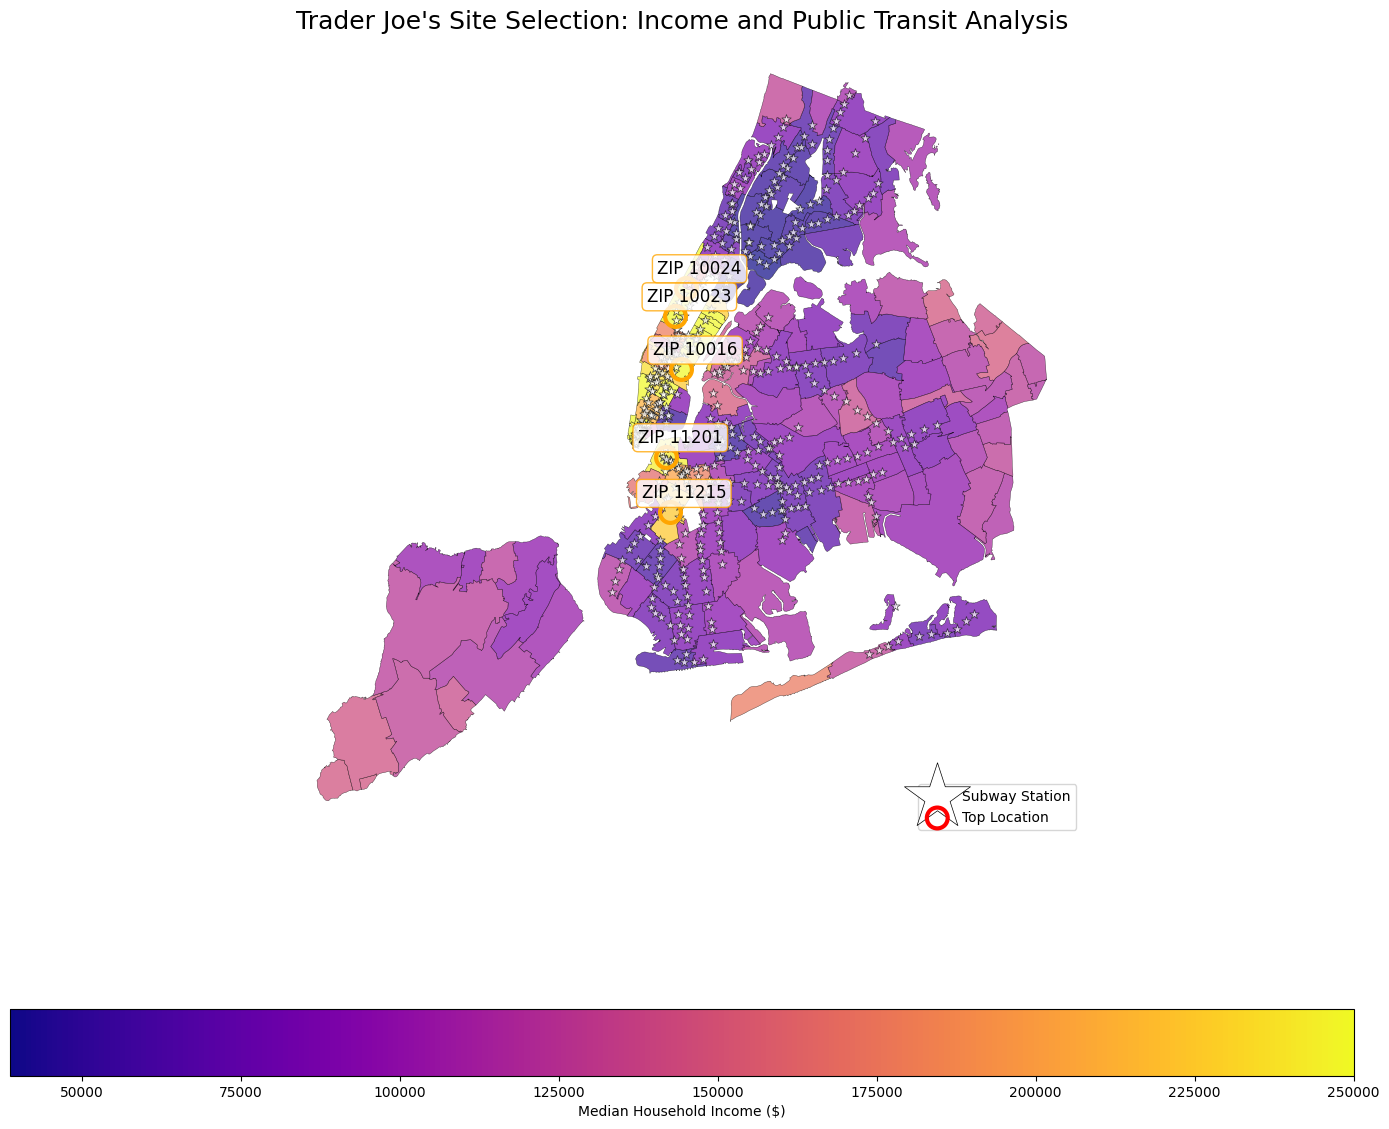

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

# Define utility function for normalization
def min_max_normalize(series):
    if series.max() == series.min():
        return series / series.max() if series.max() > 0 else series
    return (series - series.min()) / (series.max() - series.min())

# Load the ZIP code data
file_path = "cleaned_data/merged_final_data.geojson"
nyc_data = gpd.read_file(file_path)

# Load the subway station data
subway_path = "subway-stations.geojson"
subway_data = gpd.read_file(subway_path)

# Clean up subway data - remove stations with invalid geometries
subway_clean = subway_data[~subway_data.geometry.isna()]
print(f"Found {len(subway_clean)} valid subway stations")

# Calculate area in square kilometers for each ZIP code
nyc_data['area_sqkm'] = nyc_data.to_crs(epsg=32118).area / 1000000

# Count subway stations in each ZIP code
nyc_data['subway_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    stations_in_area = subway_clean[subway_clean.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'subway_count'] = len(stations_in_area)

# Calculate and normalize subway station density
nyc_data['subway_density'] = nyc_data['subway_count'] / nyc_data['area_sqkm']
nyc_data['subway_density_normalized'] = min_max_normalize(nyc_data['subway_density'])

# Filter for income > 120K
high_income_areas = nyc_data[nyc_data['Median_Household_Income'] > 120000].copy()
print(f"Number of high income ZIP areas (>$120K): {len(high_income_areas)}")

# Normalize population data
high_income_areas['Population_Normalized'] = min_max_normalize(high_income_areas['Total_Population'])
high_income_areas['Young_Adult_Normalized'] = min_max_normalize(high_income_areas['Percent_25_to_44'])
high_income_areas['White_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_White'])
high_income_areas['Asian_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_Asian'])

# Create a composite score with custom weights including subway density
high_income_areas['TJ_Score'] = (
    0.18 * high_income_areas['Income_Normalized'] +      # Income
    0.20 * high_income_areas['Education_Normalized'] +   # Education
    0.15 * high_income_areas['Population_Normalized'] +  # Total population
    0.15 * high_income_areas['Young_Adult_Normalized'] + # Young adults (25-44)
    0.10 * high_income_areas['White_Pop_Normalized'] +   # White population
    0.10 * high_income_areas['Asian_Pop_Normalized'] +   # Asian population
    0.12 * high_income_areas['subway_density_normalized'] # Subway access
)

# Identify top 5 most suitable ZIP codes
top_areas = high_income_areas.nlargest(5, 'TJ_Score')

# ---------- VISUALIZATION 1: TJ SUITABILITY SCORE WITH SUBWAY STATIONS ----------
fig, ax = plt.subplots(figsize=(12, 10))

# Create custom colormap for TJ suitability
tj_cmap = LinearSegmentedColormap.from_list('tj_colors', ['#c6ecc6', '#86c486', '#429042', '#0a5c0a'])

# Plot all areas in light gray as background
nyc_data.plot(ax=ax, edgecolor='black', linewidth=0.3, color='lightgrey', alpha=0.3)

# Plot high income areas with suitability score
high_income_areas.plot(
    column='TJ_Score',
    cmap=tj_cmap,
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
)

# Plot subway stations
subway_clean.plot(ax=ax, marker='o', color='blue', markersize=15, alpha=0.7)

# Add legend for subway stations
ax.scatter([], [], c='blue', alpha=0.7, s=15**2, label='Subway Stations')
ax.legend(loc='lower right')

# Label top 5 most suitable areas
for idx, row in top_areas.iterrows():
    zipcode = row['ZCTA']
    score = round(row['TJ_Score'], 3)
    stations = int(row['subway_count'])
    ax.annotate(f"{zipcode}\n(Score: {score}, Stations: {stations})", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7))

ax.set_title("Optimal Locations for New Trader Joe's Store\n(With Subway Access)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ---------- VISUALIZATION 2: DETAILED MAP WITH BASEMAP ----------
try:
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Convert to Web Mercator for compatibility with contextily
    high_income_areas_web = high_income_areas.to_crs(epsg=3857)
    subway_clean_web = subway_clean.to_crs(epsg=3857)
    
    # Plot with basemap for context
    high_income_areas_web.plot(
        column='TJ_Score',
        cmap=tj_cmap,
        legend=True,
        ax=ax,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Plot subway stations
    subway_clean_web.plot(ax=ax, marker='o', color='blue', markersize=20, 
                          alpha=0.7, edgecolor='white', linewidth=0.5)
    
    # Highlight top areas
    top_areas_web = high_income_areas_web.nlargest(5, 'TJ_Score')
    top_areas_web.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
    
    # Add annotations for top locations
    for idx, row in top_areas_web.iterrows():
        zipcode = row['ZCTA']
        stations = int(row['subway_count'])
        ax.annotate(f"{zipcode}\n({stations} stations)", 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=10, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='red', alpha=0.8))
    
    ax.set_title("Optimal Locations for New Trader Joe's Store with Subway Access", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error adding basemap: {e}")

# ---------- VISUALIZATION 3: TABULAR RESULTS ----------
# Display top 10 areas with detailed metrics
top_10 = high_income_areas.nlargest(10, 'TJ_Score')[['ZCTA', 'TJ_Score', 'Median_Household_Income', 
                                                    'Total_Population', 'Percent_25_to_44', 
                                                    'Percent_White', 'Percent_Asian', 
                                                    'Education_Normalized', 'subway_count', 'subway_density']]

print("\nTop 10 Most Suitable ZIP Codes for Trader Joe's:")
top_10_display = top_10.copy()
top_10_display['Education_Level'] = top_10_display['Education_Normalized'].apply(lambda x: f"{x*100:.1f}%")
top_10_display['TJ_Score'] = top_10_display['TJ_Score'].apply(lambda x: f"{x:.3f}")
top_10_display['Median_Household_Income'] = top_10_display['Median_Household_Income'].apply(lambda x: f"${int(x):,}")
top_10_display['Subway Density'] = top_10_display['subway_density'].apply(lambda x: f"{x:.2f} per km²")

# Display formatted results
display(top_10_display[['ZCTA', 'TJ_Score', 'Median_Household_Income', 'Total_Population',
                       'Percent_25_to_44', 'Percent_White', 'Percent_Asian', 
                       'Education_Level', 'subway_count', 'Subway Density']])

# ---------- VISUALIZATION 4: INCOME MAP WITH SUBWAY OVERLAY ----------
fig, ax = plt.subplots(figsize=(14, 12))

# Plot income distribution with subway stations
nyc_data.plot(
    column='Median_Household_Income',
    cmap='plasma',
    ax=ax,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Median Household Income ($)", 'orientation': 'horizontal'}
)

# Plot subway stations
subway_clean.plot(ax=ax, marker='*', color='white', markersize=50, 
                 alpha=0.7, edgecolor='black', linewidth=0.5)

# Highlight top 5 locations
for idx, row in top_areas.iterrows():
    # Draw a circle around top locations
    circle_color = 'red' if row['TJ_Score'] > 0.7 else 'orange'
    ax.plot(row.geometry.centroid.x, row.geometry.centroid.y, 'o', 
            markersize=15, markerfacecolor='none', markeredgecolor=circle_color, 
            markeredgewidth=3)
    
    # Add labels
    ax.annotate(f"ZIP {row['ZCTA']}", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(10, 10),
                textcoords="offset points",
                ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=circle_color, alpha=0.8))

# Add legend
ax.scatter([], [], marker='*', c='white', s=50**2, edgecolors='black', linewidths=0.5, label='Subway Station')
ax.scatter([], [], marker='o', c='none', edgecolors='red', s=15**2, linewidths=3, label='Top Location')
ax.legend(loc='lower right')

ax.set_title("Trader Joe's Site Selection: Income and Public Transit Analysis", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Found 470 valid subway stations
Found 15 ZIP codes with existing stores
Existing store ZIP codes: ['10001', '10002', '10003', '10009', '10010', '10013', '10016', '10019', '10022', '10023', '10025', '10027', '10028', '10036', '11205']
Found 25 ZIP codes adjacent to existing stores
Number of high income ZIP areas (>$120K) without existing stores: 31


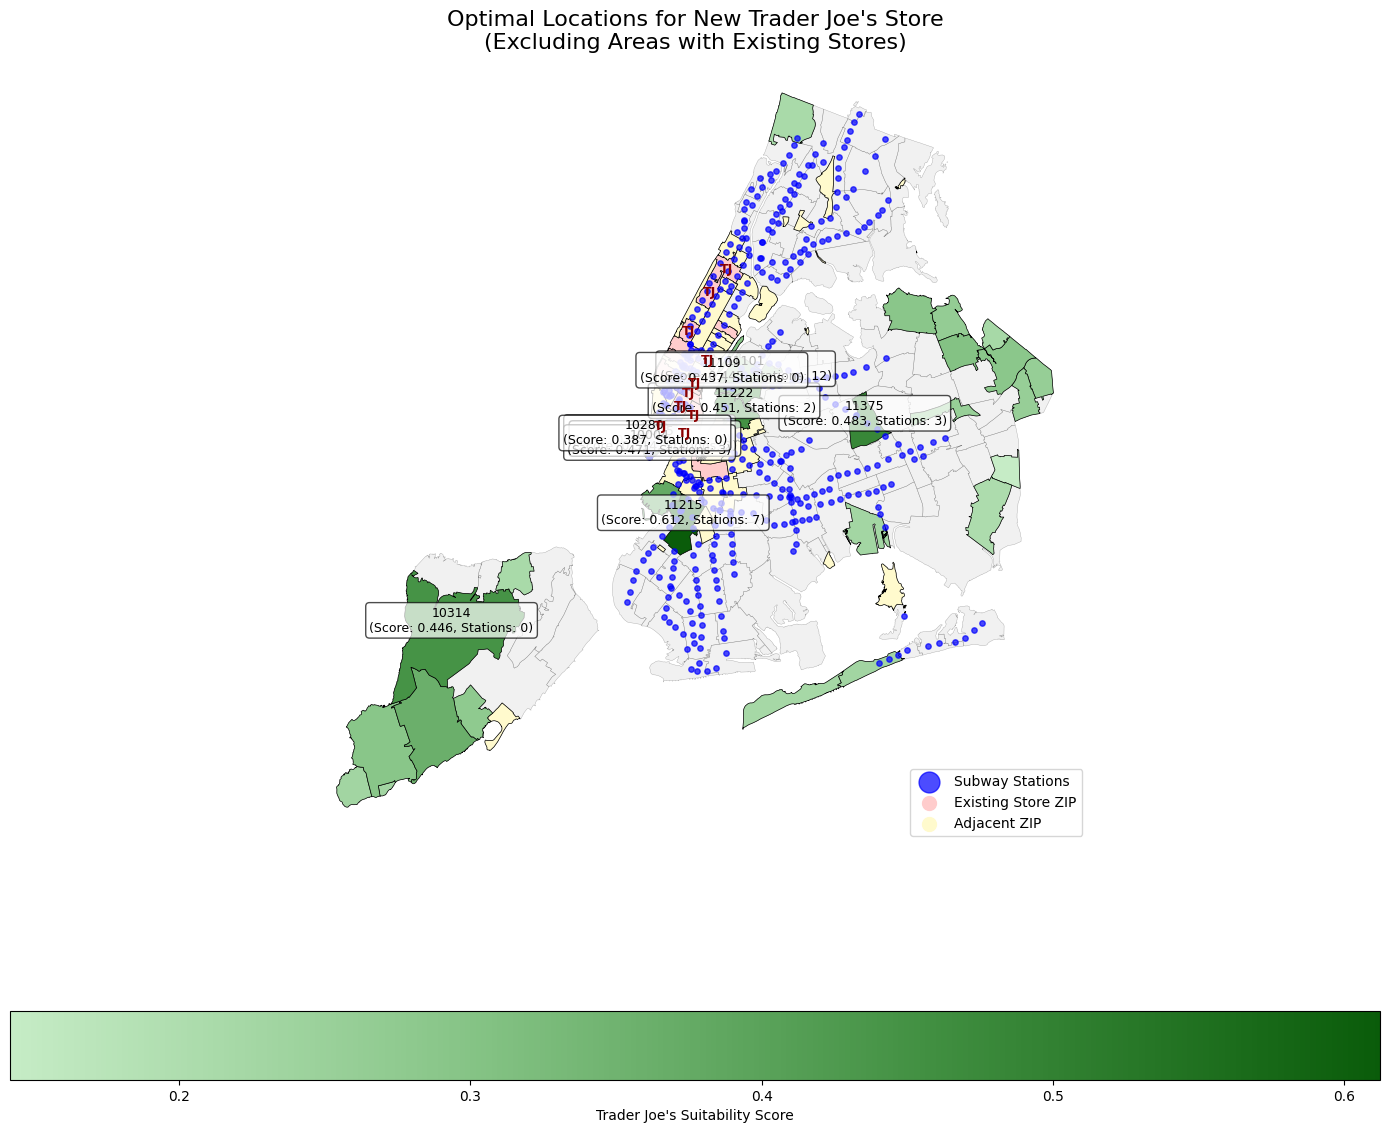

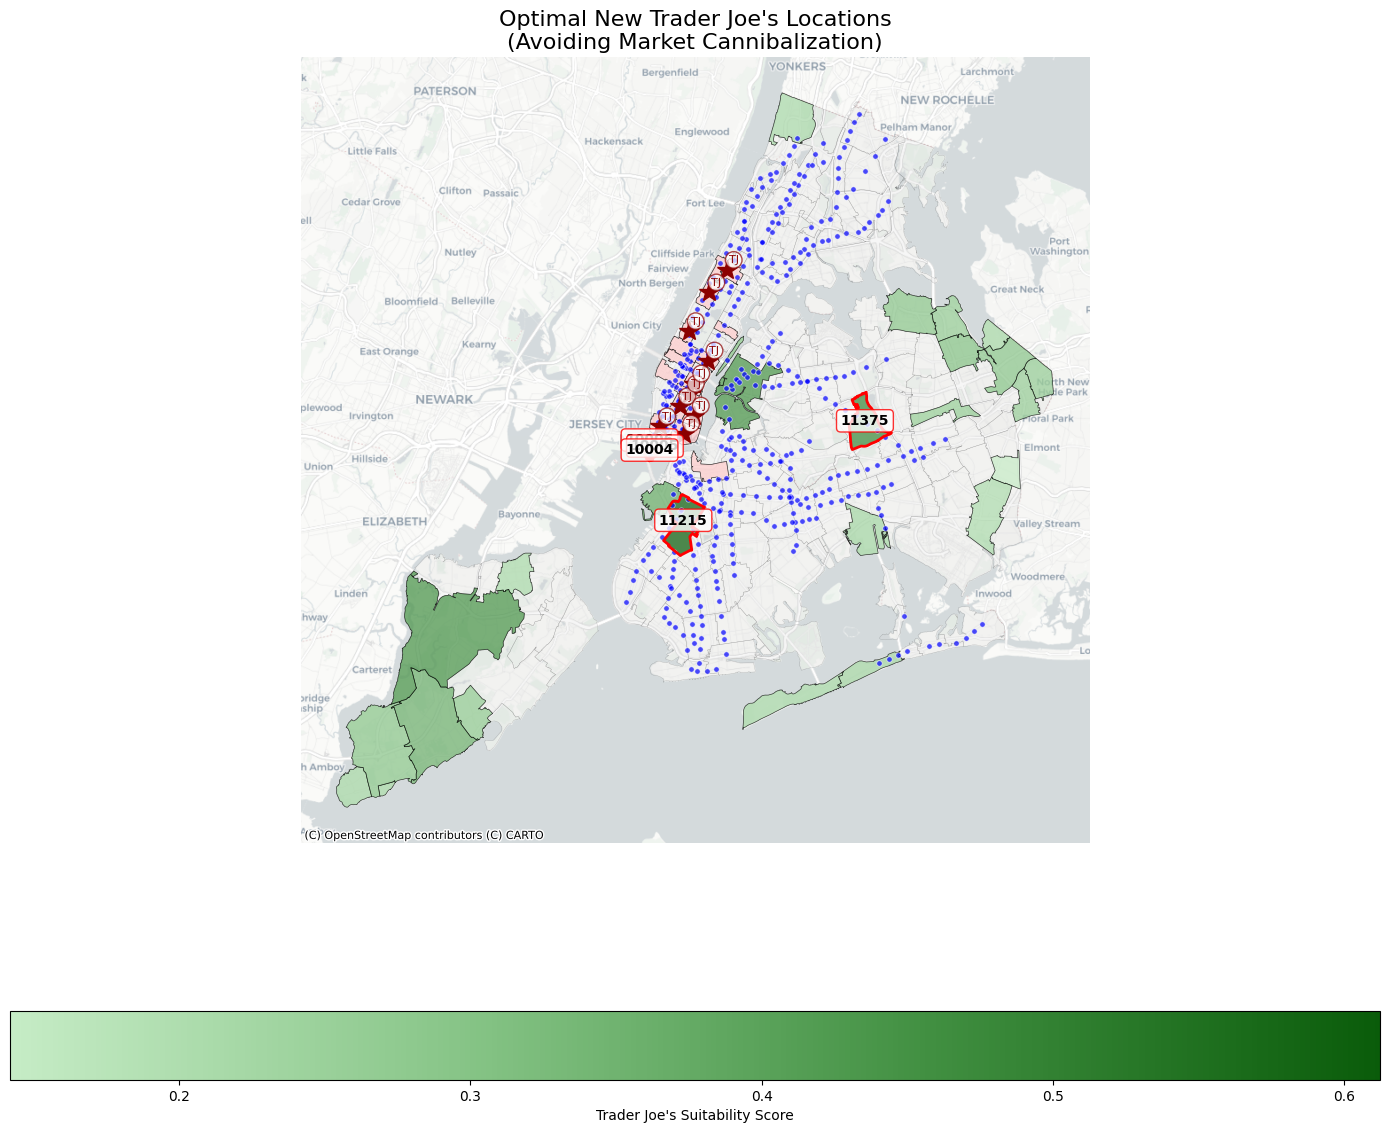


Top 10 Most Suitable ZIP Codes for New Trader Joe's (Excluding Existing Store Areas):


ZCTA TJ_Score Median_Household_Income  Total_Population  \
103  11215    0.612                $223,697           70922.0   
6    10006    0.562                $250,000            4475.0   
5    10005    0.514                $250,000            9238.0   
148  11375    0.483                $135,095           75320.0   
4    10004    0.471                $250,000            3875.0   
109  11222    0.451                $148,503           41418.0   
59   10314    0.446                $123,776           93539.0   
71   11101    0.445                $135,304           39007.0   
82   11109    0.437                $227,614            7388.0   
44   10280    0.387                $250,000            8668.0   

     Percent_25_to_44  Percent_White  Percent_Asian Education_Level  \
103              39.5           71.2            9.1           86.8%   
6                61.5           65.5           23.6            4.0%   
5                57.5           67.7           14.2           10.8%   
148              27.7           50.9           28.0           71.5%   
4                52.8           63.5           23.8            3.6%   
109              53.6           71.0            5.8           43.6%   
59               25.7           65.6           18.6           49.6%   
71               51.8           37.5           31.2           39.8%   
82               58.0           61.6           27.9            8.5%   
44               36.3           61.5           28.4           11.1%   

     subway_count Subway Density  
103             7   1.23 per km²  
6               4  15.88 per km²  
5               2  10.35 per km²  
148             3   0.58 per km²  
4               3   7.85 per km²  
109             2   0.51 per km²  
59              0   0.00 per km²  
71             12   1.78 per km²  
82              0   0.00 per km²  
44              0   0.00 per km²


RECOMMENDED LOCATIONS ANALYSIS:

1. ZIP CODE 11215:
   • Median Household Income: $223,697
   • Education Level: 86.8% (normalized)
   • Young Adult Population (25-44): 39.5%
   • Subway Access: 7 stations
   • Away from existing Trader Joe's and competitors
   • Approximate distance to nearest Trader Joe's (ZIP 10002): 3.7 miles

2. ZIP CODE 10006:
   • Median Household Income: $250,000
   • Education Level: 4.0% (normalized)
   • Young Adult Population (25-44): 61.5%
   • Subway Access: 4 stations
   • Away from existing Trader Joe's and competitors
   • Approximate distance to nearest Trader Joe's (ZIP 10013): 0.9 miles

3. ZIP CODE 10005:
   • Median Household Income: $250,000
   • Education Level: 10.8% (normalized)
   • Young Adult Population (25-44): 57.5%
   • Subway Access: 2 stations
   • Away from existing Trader Joe's and competitors
   • Approximate distance to nearest Trader Joe's (ZIP 10013): 1.0 miles

4. ZIP CODE 11375:
   • Median Household Income: $135,095
   • Educ

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import json
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

# Define utility function for normalization
def min_max_normalize(series):
    if series.max() == series.min():
        return series / series.max() if series.max() > 0 else series
    return (series - series.min()) / (series.max() - series.min())

# Load the ZIP code data
file_path = "cleaned_data/merged_final_data.geojson"
nyc_data = gpd.read_file(file_path)

# Load the subway station data
subway_path = "subway-stations.geojson"
subway_data = gpd.read_file(subway_path)
subway_clean = subway_data[~subway_data.geometry.isna()]
print(f"Found {len(subway_clean)} valid subway stations")

# Load existing store locations
with open("exisiting_shops_zip_code.json", "r") as f:
    existing_stores = json.load(f)

# Create a set of all ZIP codes with existing stores
existing_zips = set()
for store_type, zips in existing_stores.items():
    existing_zips.update(zips)
print(f"Found {len(existing_zips)} ZIP codes with existing stores")
print(f"Existing store ZIP codes: {sorted(existing_zips)}")

# Find adjacent ZIP codes to avoid market cannibalization
adjacent_zips = set()
existing_areas = nyc_data[nyc_data['ZCTA'].isin(existing_zips)]

for idx, area in nyc_data.iterrows():
    # Check if this area touches any existing store area
    if any(area.geometry.touches(existing.geometry) for _, existing in existing_areas.iterrows()):
        adjacent_zips.add(area['ZCTA'])

# Remove the existing ZIP codes from adjacent ZIP codes (they're already excluded)
adjacent_zips = adjacent_zips - existing_zips
print(f"Found {len(adjacent_zips)} ZIP codes adjacent to existing stores")

# Calculate area in square kilometers for each ZIP code
nyc_data['area_sqkm'] = nyc_data.to_crs(epsg=32118).area / 1000000

# Count subway stations in each ZIP code
nyc_data['subway_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    stations_in_area = subway_clean[subway_clean.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'subway_count'] = len(stations_in_area)

# Calculate and normalize subway station density
nyc_data['subway_density'] = nyc_data['subway_count'] / nyc_data['area_sqkm']
nyc_data['subway_density_normalized'] = min_max_normalize(nyc_data['subway_density'])

# Filter for income > 120K and exclude areas with existing stores or adjacent to them
high_income_areas = nyc_data[
    (nyc_data['Median_Household_Income'] > 120000) & 
    (~nyc_data['ZCTA'].isin(existing_zips)) & 
    (~nyc_data['ZCTA'].isin(adjacent_zips))
].copy()

print(f"Number of high income ZIP areas (>$120K) without existing stores: {len(high_income_areas)}")

# Normalize population data
high_income_areas['Population_Normalized'] = min_max_normalize(high_income_areas['Total_Population'])
high_income_areas['Young_Adult_Normalized'] = min_max_normalize(high_income_areas['Percent_25_to_44'])
high_income_areas['White_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_White'])
high_income_areas['Asian_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_Asian'])

# Create a composite score with custom weights including subway density
high_income_areas['TJ_Score'] = (
    0.18 * high_income_areas['Income_Normalized'] +      # Income
    0.20 * high_income_areas['Education_Normalized'] +   # Education
    0.15 * high_income_areas['Population_Normalized'] +  # Total population
    0.15 * high_income_areas['Young_Adult_Normalized'] + # Young adults (25-44)
    0.10 * high_income_areas['White_Pop_Normalized'] +   # White population
    0.10 * high_income_areas['Asian_Pop_Normalized'] +   # Asian population
    0.12 * high_income_areas['subway_density_normalized'] # Subway access
)

# Identify top 5 most suitable ZIP codes
top_areas = high_income_areas.nlargest(5, 'TJ_Score')

# ---------- VISUALIZATION 1: OPPORTUNITY MAP WITHOUT EXISTING STORES ----------
fig, ax = plt.subplots(figsize=(14, 12))

# Create custom colormap for TJ suitability
tj_cmap = LinearSegmentedColormap.from_list('tj_colors', ['#c6ecc6', '#86c486', '#429042', '#0a5c0a'])

# Plot all areas in light gray as background
nyc_data.plot(ax=ax, edgecolor='black', linewidth=0.3, color='lightgrey', alpha=0.3)

# Plot areas with existing stores in light red
existing_store_areas = nyc_data[nyc_data['ZCTA'].isin(existing_zips)]
existing_store_areas.plot(ax=ax, color='#ffcccc', edgecolor='black', linewidth=0.5)

# Plot adjacent areas in light yellow
adjacent_areas = nyc_data[nyc_data['ZCTA'].isin(adjacent_zips)]
adjacent_areas.plot(ax=ax, color='#fffacd', edgecolor='black', linewidth=0.5)

# Plot high income areas with suitability score
high_income_areas.plot(
    column='TJ_Score',
    cmap=tj_cmap,
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
)

# Plot subway stations
subway_clean.plot(ax=ax, marker='o', color='blue', markersize=15, alpha=0.7)

# Add legend items
ax.scatter([], [], c='blue', alpha=0.7, s=15**2, label='Subway Stations')
ax.scatter([], [], c='#ffcccc', s=100, label='Existing Store ZIP')
ax.scatter([], [], c='#fffacd', s=100, label='Adjacent ZIP')
ax.legend(loc='lower right')

# Label top 5 most suitable areas
for idx, row in top_areas.iterrows():
    zipcode = row['ZCTA']
    score = round(row['TJ_Score'], 3)
    stations = int(row['subway_count'])
    ax.annotate(f"{zipcode}\n(Score: {score}, Stations: {stations})", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7))

# Label existing Trader Joe's locations
for idx, row in nyc_data[nyc_data['ZCTA'].isin(existing_stores['Trader Joe\'s'])].iterrows():
    ax.annotate("TJ", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', va='center', fontsize=9, fontweight='bold', color='darkred')

ax.set_title("Optimal Locations for New Trader Joe's Store\n(Excluding Areas with Existing Stores)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ---------- VISUALIZATION 2: MAP WITH EXISTING STORE CONTEXT ----------
try:
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Convert to Web Mercator for compatibility with contextily
    nyc_data_web = nyc_data.to_crs(epsg=3857)
    high_income_areas_web = high_income_areas.to_crs(epsg=3857)
    subway_clean_web = subway_clean.to_crs(epsg=3857)
    existing_store_areas_web = existing_store_areas.to_crs(epsg=3857)
    
    # Plot with basemap for context
    nyc_data_web.plot(
        ax=ax, 
        color='lightgrey', 
        edgecolor='black', 
        linewidth=0.3, 
        alpha=0.2
    )
    
    # Plot areas with existing stores
    existing_store_areas_web.plot(
        ax=ax, 
        color='#ffcccc', 
        edgecolor='black', 
        linewidth=0.5, 
        alpha=0.7
    )
    
    # Plot high income areas with suitability score
    high_income_areas_web.plot(
        column='TJ_Score',
        cmap=tj_cmap,
        legend=True,
        ax=ax,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Plot subway stations
    subway_clean_web.plot(ax=ax, marker='o', color='blue', markersize=15, 
                        alpha=0.7, edgecolor='white', linewidth=0.5)
    
    # Highlight top areas
    top_areas_web = high_income_areas_web.nlargest(5, 'TJ_Score')
    top_areas_web.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
    
    # Add annotations for existing Trader Joe's stores
    tj_stores_web = nyc_data_web[nyc_data_web['ZCTA'].isin(existing_stores['Trader Joe\'s'])]
    for idx, row in tj_stores_web.iterrows():
        ax.plot(row.geometry.centroid.x, row.geometry.centroid.y, 
                marker='*', markersize=15, color='darkred')
        ax.annotate('TJ', 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    xytext=(5, 5),
                    textcoords="offset points",
                    ha='center', fontsize=8, color='darkred',
                    bbox=dict(boxstyle="circle,pad=0.3", fc='white', ec='darkred', alpha=0.7))
    
    # Add annotations for top locations
    for idx, row in top_areas_web.iterrows():
        zipcode = row['ZCTA']
        ax.annotate(zipcode, 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=10, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='red', alpha=0.8))
    
    ax.set_title("Optimal New Trader Joe's Locations\n(Avoiding Market Cannibalization)", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error adding basemap: {e}")
    print("Continuing without basemap...")

# ---------- VISUALIZATION 3: TABULAR RESULTS ----------
# Display top 10 areas with detailed metrics
top_10 = high_income_areas.nlargest(10, 'TJ_Score')[['ZCTA', 'TJ_Score', 'Median_Household_Income', 
                                                     'Total_Population', 'Percent_25_to_44', 
                                                     'Percent_White', 'Percent_Asian', 
                                                     'Education_Normalized', 'subway_count', 'subway_density']]

print("\nTop 10 Most Suitable ZIP Codes for New Trader Joe's (Excluding Existing Store Areas):")
top_10_display = top_10.copy()
top_10_display['Education_Level'] = top_10_display['Education_Normalized'].apply(lambda x: f"{x*100:.1f}%")
top_10_display['TJ_Score'] = top_10_display['TJ_Score'].apply(lambda x: f"{x:.3f}")
top_10_display['Median_Household_Income'] = top_10_display['Median_Household_Income'].apply(lambda x: f"${int(x):,}")
top_10_display['Subway Density'] = top_10_display['subway_density'].apply(lambda x: f"{x:.2f} per km²")

# Display formatted results
display(top_10_display[['ZCTA', 'TJ_Score', 'Median_Household_Income', 'Total_Population',
                        'Percent_25_to_44', 'Percent_White', 'Percent_Asian', 
                        'Education_Level', 'subway_count', 'Subway Density']])

# Generate explanation of why these are good locations
print("\nRECOMMENDED LOCATIONS ANALYSIS:")
for i, (idx, row) in enumerate(top_areas.iterrows(), 1):
    zipcode = row['ZCTA']
    income = int(row['Median_Household_Income'])
    education = row['Education_Normalized'] * 100
    young_adult = row['Percent_25_to_44']
    subway = row['subway_count']
    print(f"\n{i}. ZIP CODE {zipcode}:")
    print(f"   • Median Household Income: ${income:,}")
    print(f"   • Education Level: {education:.1f}% (normalized)")  
    print(f"   • Young Adult Population (25-44): {young_adult}%")
    print(f"   • Subway Access: {subway} stations")
    print(f"   • Away from existing Trader Joe's and competitors")
    
    # Calculate straight-line distance to nearest existing TJ
    min_distance = float('inf')
    nearest_zip = None
    
    for existing_zip in existing_stores['Trader Joe\'s']:
        existing_area = nyc_data[nyc_data['ZCTA'] == existing_zip].iloc[0]
        distance = row.geometry.centroid.distance(existing_area.geometry.centroid)
        if distance < min_distance:
            min_distance = distance
            nearest_zip = existing_zip
    
    # Convert distance to approximate miles (very rough estimate)
    miles = min_distance * 69
    print(f"   • Approximate distance to nearest Trader Joe's (ZIP {nearest_zip}): {miles:.1f} miles")

Found 470 valid subway stations
Found 15 ZIP codes with existing stores
Found 6 ZIP codes with impossible locations
Found 25 ZIP codes adjacent to existing stores
Number of high income ZIP areas (>$120K) after all exclusions: 28


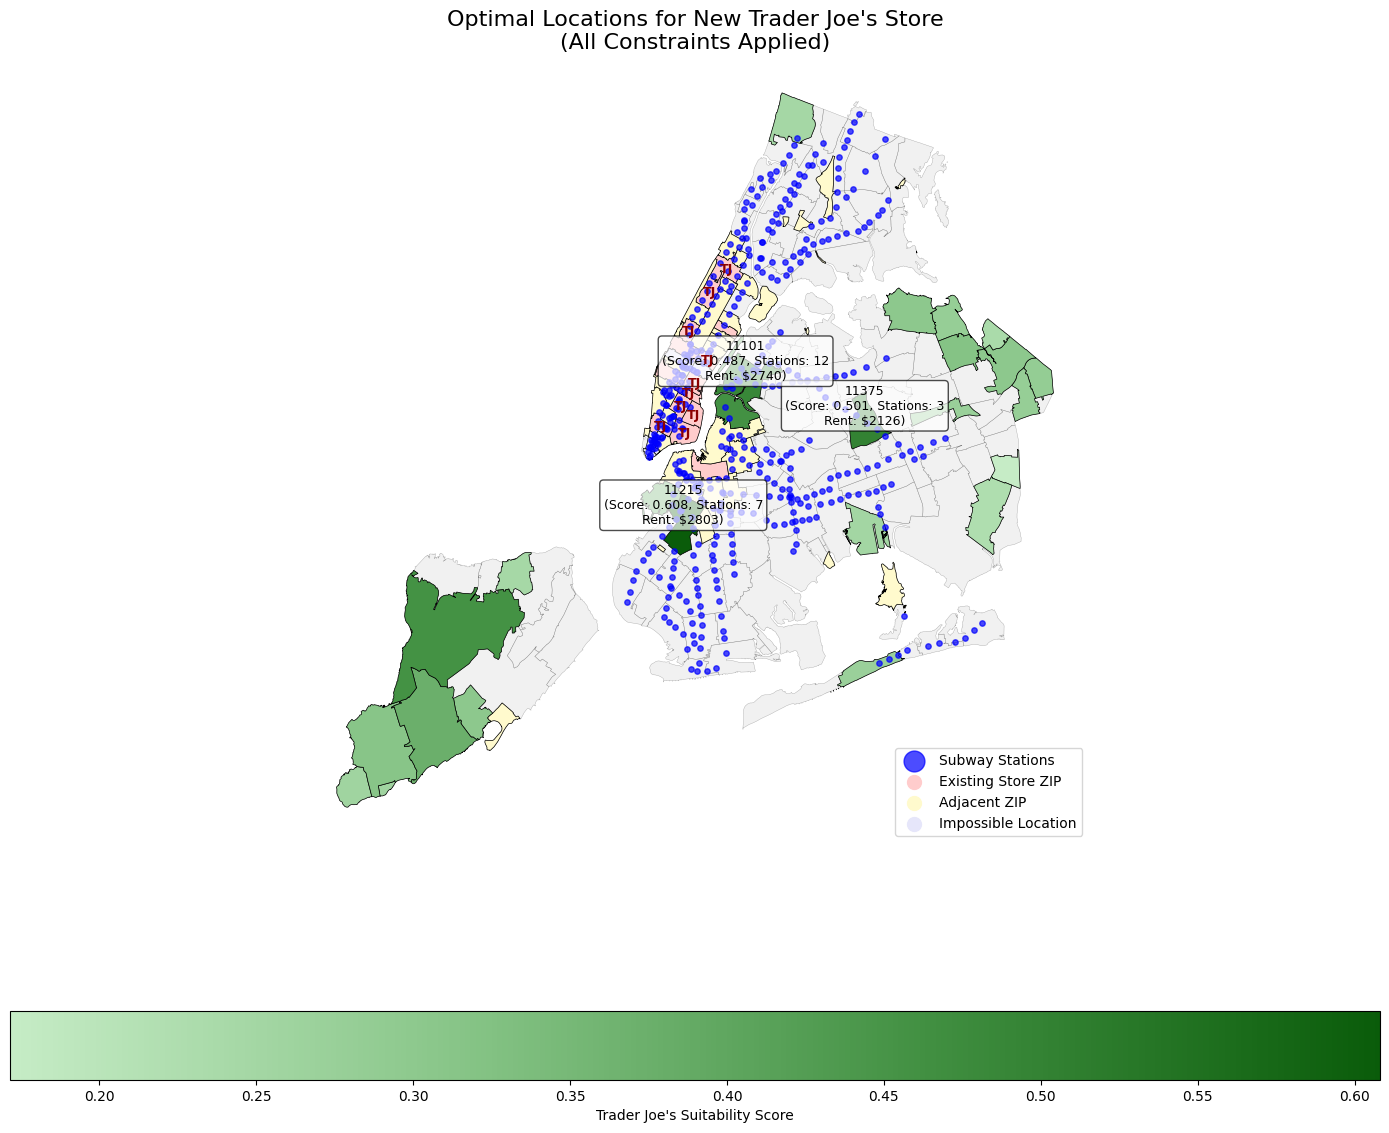

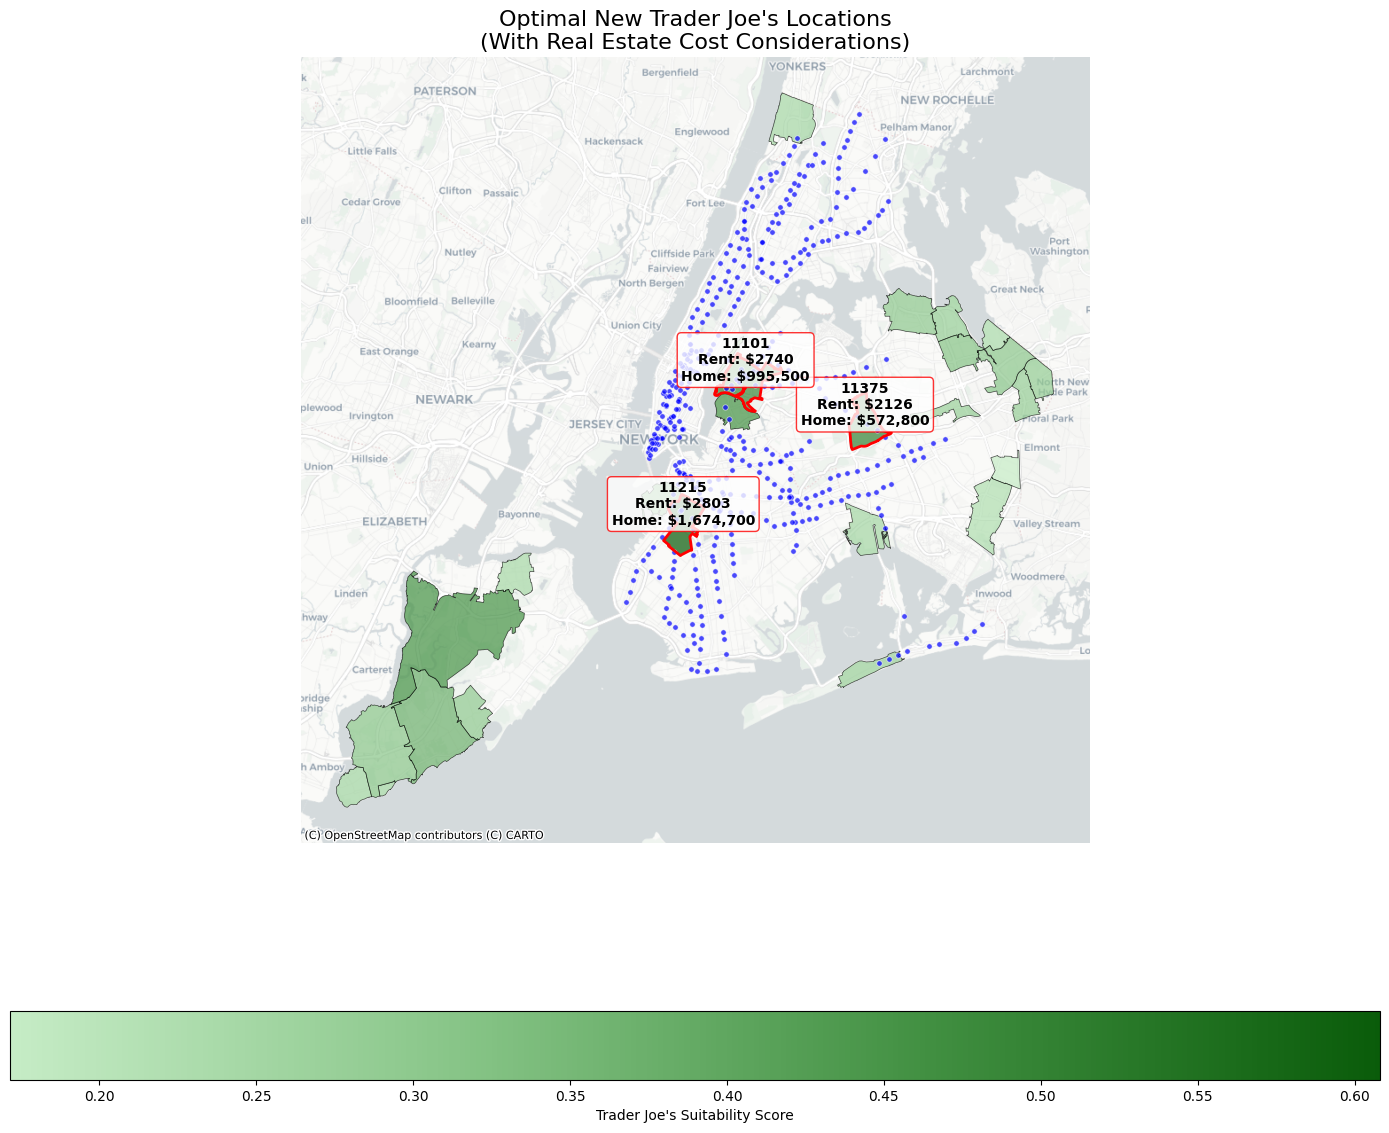


Top 3 Most Suitable ZIP Codes for New Trader Joe's (All Factors Considered):


ZCTA TJ_Score Median_Household_Income  Total_Population  \
103  11215    0.608                $223,697           70922.0   
148  11375    0.501                $135,095           75320.0   
71   11101    0.487                $135,304           39007.0   

     Percent_25_to_44  Percent_White  Percent_Asian Education_Level  \
103              39.5           71.2            9.1           86.8%   
148              27.7           50.9           28.0           71.5%   
71               51.8           37.5           31.2           39.8%   

     subway_count Subway Density Median_Gross_Rent Median_Home_Value  
103             7   1.23 per km²            $2,803        $1,674,700  
148             3   0.58 per km²            $2,126          $572,800  
71             12   1.78 per km²            $2,740          $995,500


🌟 FINAL RECOMMENDATIONS FOR NEW TRADER JOE'S LOCATION 🌟

1. ZIP CODE 11215 (Score: 0.608):
   📊 Demographics:
      • Population: 70,922 residents
      • Median Income: $223,697
      • Young Adults (25-44): 39.5%
      • White Population: 71.2%
      • Asian Population: 9.1%
   🚇 Transportation:
      • Subway Stations: 7
      • Subway Density: 1.23 stations per km²
   💰 Real Estate Costs:
      • Median Home Value: $1,674,700
      • Median Gross Rent: $2,803
   ✅ Other Advantages:
      • No existing Trader Joe's in area
      • No direct competition from Whole Foods, Wegmans, or Fairway
      • Sufficient distance from existing store locations
      • Not in an impossible development location

2. ZIP CODE 11375 (Score: 0.501):
   📊 Demographics:
      • Population: 75,320 residents
      • Median Income: $135,095
      • Young Adults (25-44): 27.7%
      • White Population: 50.9%
      • Asian Population: 28.0%
   🚇 Transportation:
      • Subway Stations: 3
      • Subway Densi

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import json
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

# Define utility function for normalization
def min_max_normalize(series):
    if series.max() == series.min():
        return series / series.max() if series.max() > 0 else series
    return (series - series.min()) / (series.max() - series.min())

# Load the ZIP code data
file_path = "cleaned_data/merged_final_data.geojson"
nyc_data = gpd.read_file(file_path)

# Load the subway station data
subway_path = "subway-stations.geojson"
subway_data = gpd.read_file(subway_path)
subway_clean = subway_data[~subway_data.geometry.isna()]
print(f"Found {len(subway_clean)} valid subway stations")

# Load existing store locations
with open("exisiting_shops_zip_code.json", "r") as f:
    existing_stores = json.load(f)

# Load impossible places
with open("impossible_places.json", "r") as f:
    impossible_places = json.load(f)

# Create sets of ZIP codes to exclude
existing_zips = set()
impossible_zips = set()

# Gather existing store ZIPs
for store_type, zips in existing_stores.items():
    existing_zips.update(zips)
    
# Gather impossible place ZIPs
for place in impossible_places:
    if place["zipcode"]:  # Some might be null
        impossible_zips.add(place["zipcode"])
        
print(f"Found {len(existing_zips)} ZIP codes with existing stores")
print(f"Found {len(impossible_zips)} ZIP codes with impossible locations")

# Find adjacent ZIP codes to avoid market cannibalization
adjacent_zips = set()
existing_areas = nyc_data[nyc_data['ZCTA'].isin(existing_zips)]

for idx, area in nyc_data.iterrows():
    # Check if this area touches any existing store area
    if any(area.geometry.touches(existing.geometry) for _, existing in existing_areas.iterrows()):
        adjacent_zips.add(area['ZCTA'])

# Remove the existing ZIP codes from adjacent ZIP codes (they're already excluded)
adjacent_zips = adjacent_zips - existing_zips
print(f"Found {len(adjacent_zips)} ZIP codes adjacent to existing stores")

# Calculate area in square kilometers for each ZIP code
nyc_data['area_sqkm'] = nyc_data.to_crs(epsg=32118).area / 1000000

# Count subway stations in each ZIP code
nyc_data['subway_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    stations_in_area = subway_clean[subway_clean.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'subway_count'] = len(stations_in_area)

# Calculate and normalize subway station density
nyc_data['subway_density'] = nyc_data['subway_count'] / nyc_data['area_sqkm']
nyc_data['subway_density_normalized'] = min_max_normalize(nyc_data['subway_density'])

# Normalize housing costs (INVERSE - lower is better)
nyc_data['rent_inverse'] = nyc_data['Median_Gross_Rent'].max() - nyc_data['Median_Gross_Rent']
nyc_data['home_value_inverse'] = nyc_data['Median_Home_Value'].max() - nyc_data['Median_Home_Value']
nyc_data['rent_inverse_normalized'] = min_max_normalize(nyc_data['rent_inverse'])
nyc_data['home_value_inverse_normalized'] = min_max_normalize(nyc_data['home_value_inverse'])

# Filter for high income areas while excluding disqualified areas
potential_areas = nyc_data[
    (nyc_data['Median_Household_Income'] > 120000) & 
    (~nyc_data['ZCTA'].isin(existing_zips)) & 
    (~nyc_data['ZCTA'].isin(adjacent_zips)) &
    (~nyc_data['ZCTA'].isin(impossible_zips))
].copy()

print(f"Number of high income ZIP areas (>$120K) after all exclusions: {len(potential_areas)}")

# Normalize population metrics
potential_areas['Population_Normalized'] = min_max_normalize(potential_areas['Total_Population'])
potential_areas['Young_Adult_Normalized'] = min_max_normalize(potential_areas['Percent_25_to_44'])
potential_areas['White_Pop_Normalized'] = min_max_normalize(potential_areas['Percent_White'])
potential_areas['Asian_Pop_Normalized'] = min_max_normalize(potential_areas['Percent_Asian'])

# Create a composite score with updated weights including cost factors
potential_areas['TJ_Score'] = (
    0.16 * potential_areas['Income_Normalized'] +      # Income
    0.18 * potential_areas['Education_Normalized'] +   # Education
    0.14 * potential_areas['Population_Normalized'] +  # Total population
    0.14 * potential_areas['Young_Adult_Normalized'] + # Young adults (25-44)
    0.10 * potential_areas['White_Pop_Normalized'] +   # White population
    0.10 * potential_areas['Asian_Pop_Normalized'] +   # Asian population
    0.5 * potential_areas['subway_density_normalized'] + # Subway access
    0.03 * potential_areas['rent_inverse_normalized'] + # Lower rent is better
    0.03 * potential_areas['home_value_inverse_normalized'] # Lower home value is better
)

# Identify top locations
top_areas = potential_areas.nlargest(3, 'TJ_Score')

# ---------- VISUALIZATION 1: COMPREHENSIVE SUITABILITY MAP ----------
fig, ax = plt.subplots(figsize=(14, 12))

# Create custom colormap for TJ suitability
tj_cmap = LinearSegmentedColormap.from_list('tj_colors', ['#c6ecc6', '#86c486', '#429042', '#0a5c0a'])

# Plot all areas in light gray as background
nyc_data.plot(ax=ax, edgecolor='black', linewidth=0.3, color='lightgrey', alpha=0.3)

# Plot areas with existing stores in light red
existing_store_areas = nyc_data[nyc_data['ZCTA'].isin(existing_zips)]
existing_store_areas.plot(ax=ax, color='#ffcccc', edgecolor='black', linewidth=0.5)

# Plot adjacent areas in light yellow
adjacent_areas = nyc_data[nyc_data['ZCTA'].isin(adjacent_zips)]
adjacent_areas.plot(ax=ax, color='#fffacd', edgecolor='black', linewidth=0.5)

# Plot impossible areas in light purple
impossible_areas = nyc_data[nyc_data['ZCTA'].isin(impossible_zips)]
impossible_areas.plot(ax=ax, color='#e6e6fa', edgecolor='black', linewidth=0.5)

# Plot potential areas with suitability score
potential_areas.plot(
    column='TJ_Score',
    cmap=tj_cmap,
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
)

# Plot subway stations
subway_clean.plot(ax=ax, marker='o', color='blue', markersize=15, alpha=0.7)

# Add legend items
ax.scatter([], [], c='blue', alpha=0.7, s=15**2, label='Subway Stations')
ax.scatter([], [], c='#ffcccc', s=100, label='Existing Store ZIP')
ax.scatter([], [], c='#fffacd', s=100, label='Adjacent ZIP')
ax.scatter([], [], c='#e6e6fa', s=100, label='Impossible Location')
ax.legend(loc='lower right')

# Label top 5 most suitable areas
for idx, row in top_areas.iterrows():
    zipcode = row['ZCTA']
    score = round(row['TJ_Score'], 3)
    stations = int(row['subway_count'])
    rent = int(row['Median_Gross_Rent']) if not pd.isna(row['Median_Gross_Rent']) else "N/A"
    ax.annotate(f"{zipcode}\n(Score: {score}, Stations: {stations}\nRent: ${rent})", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7))

# Label existing Trader Joe's locations
for idx, row in nyc_data[nyc_data['ZCTA'].isin(existing_stores['Trader Joe\'s'])].iterrows():
    ax.annotate("TJ", 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', va='center', fontsize=9, fontweight='bold', color='darkred')

ax.set_title("Optimal Locations for New Trader Joe's Store\n(All Constraints Applied)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ---------- VISUALIZATION 2: MAP WITH BASEMAP ----------
try:
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Convert to Web Mercator for compatibility with contextily
    nyc_data_web = nyc_data.to_crs(epsg=3857)
    potential_areas_web = potential_areas.to_crs(epsg=3857)
    subway_clean_web = subway_clean.to_crs(epsg=3857)
    
    # Plot with basemap for context
    potential_areas_web.plot(
        column='TJ_Score',
        cmap=tj_cmap,
        legend=True,
        ax=ax,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': "Trader Joe's Suitability Score", 'orientation': 'horizontal'}
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Plot subway stations
    subway_clean_web.plot(ax=ax, marker='o', color='blue', markersize=15, 
                       alpha=0.7, edgecolor='white', linewidth=0.5)
    
    # Highlight top areas
    top_areas_web = potential_areas_web.nlargest(3, 'TJ_Score')
    top_areas_web.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
    
    # Add annotations for top locations
    for idx, row in top_areas_web.iterrows():
        zipcode = row['ZCTA']
        rent = int(row['Median_Gross_Rent']) if not pd.isna(row['Median_Gross_Rent']) else "N/A"
        home = "${:,}".format(int(row['Median_Home_Value']))
        ax.annotate(f"{zipcode}\nRent: ${rent}\nHome: {home}", 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=10, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='red', alpha=0.8))
    
    ax.set_title("Optimal New Trader Joe's Locations\n(With Real Estate Cost Considerations)", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error adding basemap: {e}")
    print("Continuing without basemap...")

# ---------- VISUALIZATION 3: TABULAR RESULTS ----------
# Display top locations with detailed metrics including cost factors
top_10 = potential_areas.nlargest(3, 'TJ_Score')[['ZCTA', 'TJ_Score', 'Median_Household_Income', 
                                                  'Total_Population', 'Percent_25_to_44', 
                                                  'Percent_White', 'Percent_Asian', 
                                                  'Education_Normalized', 'subway_count', 'subway_density',
                                                  'Median_Gross_Rent', 'Median_Home_Value']]

print("\nTop 3 Most Suitable ZIP Codes for New Trader Joe's (All Factors Considered):")
top_10_display = top_10.copy()
top_10_display['Education_Level'] = top_10_display['Education_Normalized'].apply(lambda x: f"{x*100:.1f}%")
top_10_display['TJ_Score'] = top_10_display['TJ_Score'].apply(lambda x: f"{x:.3f}")
top_10_display['Median_Household_Income'] = top_10_display['Median_Household_Income'].apply(lambda x: f"${int(x):,}")
top_10_display['Subway Density'] = top_10_display['subway_density'].apply(lambda x: f"{x:.2f} per km²")
top_10_display['Median_Gross_Rent'] = top_10_display['Median_Gross_Rent'].apply(lambda x: f"${int(x):,}" if not pd.isna(x) else "N/A")
top_10_display['Median_Home_Value'] = top_10_display['Median_Home_Value'].apply(lambda x: f"${int(x):,}" if not pd.isna(x) else "N/A")

# Display formatted results
display(top_10_display[['ZCTA', 'TJ_Score', 'Median_Household_Income', 'Total_Population',
                       'Percent_25_to_44', 'Percent_White', 'Percent_Asian', 
                       'Education_Level', 'subway_count', 'Subway Density',
                       'Median_Gross_Rent', 'Median_Home_Value']])

# ---------- FINAL RECOMMENDATIONS ----------
print("\n🌟 FINAL RECOMMENDATIONS FOR NEW TRADER JOE'S LOCATION 🌟")
print("=======================================================")

for i, (idx, row) in enumerate(top_areas.iterrows(), 1):
    zipcode = row['ZCTA']
    income = int(row['Median_Household_Income'])
    score = row['TJ_Score']
    rent = int(row['Median_Gross_Rent']) if not pd.isna(row['Median_Gross_Rent']) else "N/A"
    home = int(row['Median_Home_Value'])
    subway = int(row['subway_count'])
    population = int(row['Total_Population'])
    young_adults = row['Percent_25_to_44']
    
    print(f"\n{i}. ZIP CODE {zipcode} (Score: {score:.3f}):")
    print(f"   📊 Demographics:")
    print(f"      • Population: {population:,} residents")
    print(f"      • Median Income: ${income:,}")
    print(f"      • Young Adults (25-44): {young_adults}%")
    print(f"      • White Population: {row['Percent_White']}%")
    print(f"      • Asian Population: {row['Percent_Asian']}%")
    
    print(f"   🚇 Transportation:")
    print(f"      • Subway Stations: {subway}")
    print(f"      • Subway Density: {row['subway_density']:.2f} stations per km²")
    
    print(f"   💰 Real Estate Costs:")
    print(f"      • Median Home Value: ${home:,}")
    rent_str = f"${rent:,}" if rent != "N/A" else "N/A"
    print(f"      • Median Gross Rent: {rent_str}")
    
    print(f"   ✅ Other Advantages:")
    print(f"      • No existing Trader Joe's in area")
    print(f"      • No direct competition from Whole Foods, Wegmans, or Fairway")
    print(f"      • Sufficient distance from existing store locations")
    print(f"      • Not in an impossible development location")

print("\n=======================================================")
print("Analysis complete. These locations represent the optimal balance of demographics,")
print("transportation access, and real estate costs while avoiding market cannibalization.")

In [ ]:
# # Create a dashboard showing key metrics for top 3 areas
# top_3 = high_income_areas.nlargest(3, 'TJ_Score')
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# for i, (idx, row) in enumerate(top_3.iterrows()):
#     zipcode = row['ZCTA']
    
#     # Prepare data for radar chart
#     categories = ['Income', 'Education', 'Population', 'Age 25-44', 'White Pop', 'Asian Pop']
#     values = [
#         row['Income_Normalized'],
#         row['Education_Normalized'],
#         row['Population_Normalized'],
#         min_max_normalize(high_income_areas['Percent_25_to_44']).loc[idx],
#         min_max_normalize(high_income_areas['Percent_White']).loc[idx],
#         min_max_normalize(high_income_areas['Percent_Asian']).loc[idx]
#     ]
    
    # # Close the loop for the radar chart
    # values = np.append(values, values[0])
    # categories = np.append(categories, categories[0])
    
    # # Create angles for radar chart
    # angles = np.linspace(0, 2*np.pi, len(categories)-1, endpoint=False)
    # angles = np.append(angles, angles[0])
    
    # # Plot radar chart
    # ax = axes[i]
    # ax.plot(angles, values, 'o-', linewidth=2)
    # ax.fill(angles, values, alpha=0.25)
    # Set up polar axes
    # ax.set_theta_offset(np.pi / 2)
    # ax.set_theta_direction(-1)
    # ax.set_thetagrids(angles[:-1] * 180/np.pi, categories[:-1])
    # ax.set_ylim(0, 1)
    # ax.set_title(f"ZIP {zipcode} - Score: {row['TJ_Score']:.3f}", fontsize=14)
    # ax.grid(True)
    
# plt.tight_layout()
# plt.show()